In [97]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

## Data Preprocessing

In [98]:
df = pd.read_csv("cars.csv")
print(df.head())
df = df.drop("Car_ID", axis=1)

   Car_ID    Brand    Model  Year  Kilometers_Driven Fuel_Type Transmission  \
0       1   Toyota  Corolla  2018              50000    Petrol       Manual   
1       2    Honda    Civic  2019              40000    Petrol    Automatic   
2       3     Ford  Mustang  2017              20000    Petrol    Automatic   
3       4   Maruti    Swift  2020              30000    Diesel       Manual   
4       5  Hyundai   Sonata  2016              60000    Diesel    Automatic   

  Owner_Type  Mileage  Engine  Power  Seats    Price  
0      First       15    1498    108      5   800000  
1     Second       17    1597    140      5  1000000  
2      First       10    4951    395      4  2500000  
3      Third       23    1248     74      5   600000  
4     Second       18    1999    194      5   850000  


#### Handling any missing values

In [99]:
missing_values = df.isnull().sum()
print(missing_values)

Brand                0
Model                0
Year                 0
Kilometers_Driven    0
Fuel_Type            0
Transmission         0
Owner_Type           0
Mileage              0
Engine               0
Power                0
Seats                0
Price                0
dtype: int64


There are 0 missing values within the dataset, so no adjustments are needed.

#### Handling categorical data

We have lots of categorical data here, so I am going to apply one-hot enconding to generate dummy variables.

In [100]:
df = pd.get_dummies(df, columns=["Year", "Brand", "Model", "Fuel_Type", "Transmission", "Owner_Type", "Seats"], drop_first=True)
print(df.shape)

(100, 83)


#### Normalising the numerical data

We have lots of ranges in values in our numerical data, here let's apply z-score normalisation to the data.

In [101]:
scaler = StandardScaler()
df[[ "Kilometers_Driven", "Mileage", "Engine", "Power"]] = scaler.fit_transform(df[[ "Kilometers_Driven", "Mileage", "Engine", "Power"]])

## Explanatory Data Analysis

We are going to build a loop of scatter graphs to see how each feature performs against price.

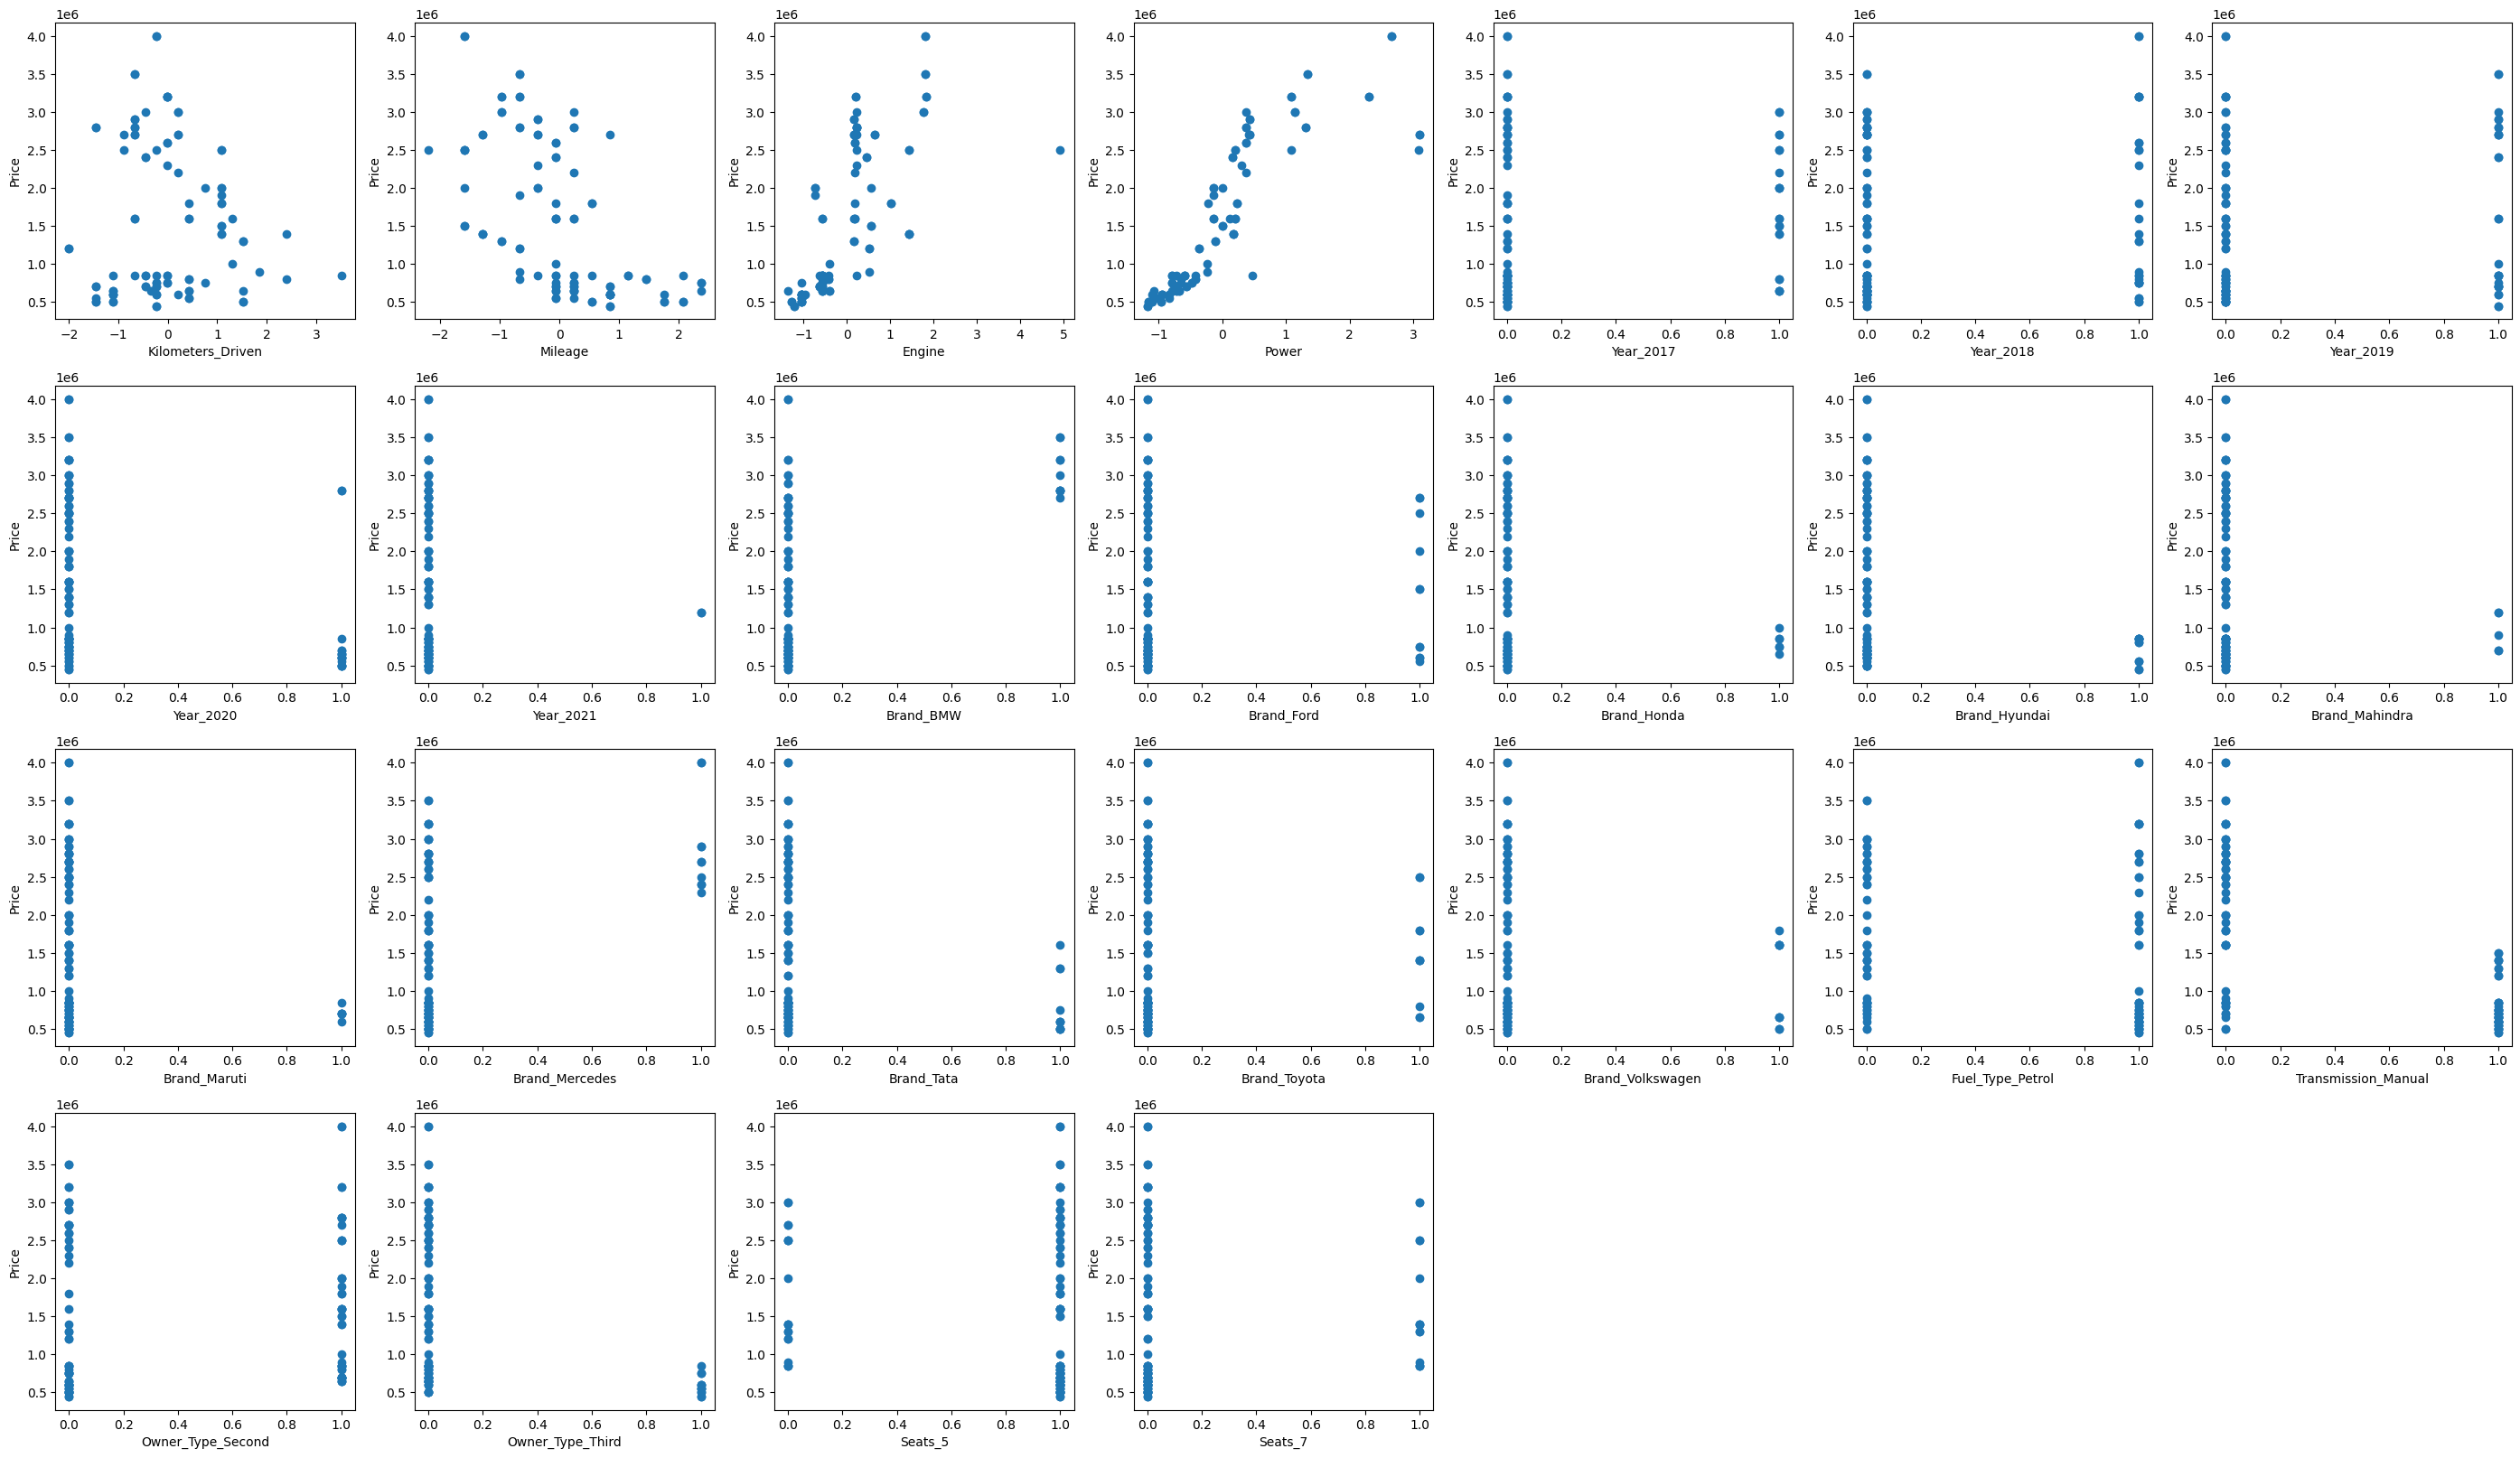

In [102]:
n_features = len(df.columns) - 1
n_cols = 7
n_rows = (n_features // n_cols) + (1 if n_features % n_cols > 0 else 0)

plt.figure(figsize=(n_cols * 4, n_rows * 4))

plot_number = 1

for i in df.columns:
    if i != "Price" and not i.startswith("Model"):
        ax = plt.subplot(n_rows, n_cols, plot_number)
        plt.scatter(x=df[i], y=df["Price"])
        plt.xlabel(i)
        plt.ylabel("Price")
        plot_number += 1

plt.tight_layout()
plt.show()

Plotting y variable on a histogram to check for skew.

count    1.000000e+02
mean     1.574000e+06
std      1.000265e+06
min      4.500000e+05
25%      7.000000e+05
50%      1.300000e+06
75%      2.500000e+06
max      4.000000e+06
Name: Price, dtype: float64


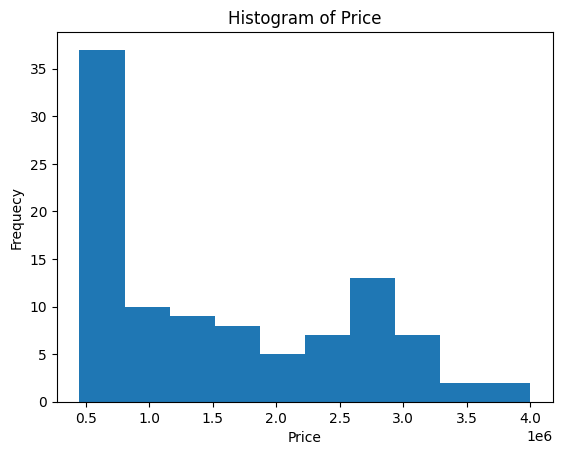

In [103]:
print(df["Price"].describe())

plt.hist(df["Price"], bins=10)
plt.title("Histogram of Price")
plt.xlabel("Price")
plt.ylabel("Frequecy")
plt.show()

The output variable shows a large right-skew. Therefore we are going to apply log transformation.

In [104]:
df["Price"] = np.log(df["Price"])

## Feature Engineering

We are going to to try filtering down some of the features as there are so many due to the vast amount of dummy variables.

As we have a mix of categorical and continuous X variables, we are going to perform correlation coefficient and ANOVA tests to filter down the features we use.

In [105]:
df.columns = [col.replace(" ", "_") for col in df.columns]
df.columns = [col.replace("-", "_") for col in df.columns]

continuous_X = df.select_dtypes(include=["float64"])
continuous_X.drop(columns="Price", inplace=True)

categorical_X = df.select_dtypes(include=["bool"])


In [106]:
correlations = {col: pearsonr(df[col], df['Price'])[0] for col in continuous_X.columns}
print(correlations)

{'Kilometers_Driven': 0.02730870354524667, 'Mileage': -0.6392021280251508, 'Engine': 0.7358433823811776, 'Power': 0.8347849389297796}


Here we can see that kilometers driven not not have a high correlation to target variable, this may be due to it's correlation with mileage. We are going to remove this variable.

In [107]:
df = df.drop(columns="Kilometers_Driven", axis=1)

In [108]:
for column in categorical_X:
    formula = f"Price ~ C({column})"
    anova_model = ols(formula, data=df).fit()
    anova_table = sm.stats.anova_lm(anova_model, typ=2)

    print(anova_table)

                 sum_sq    df         F    PR(>F)
C(Year_2017)   1.227360   1.0  2.811179  0.096797
Residual      42.786782  98.0       NaN       NaN
                 sum_sq    df         F    PR(>F)
C(Year_2018)   0.386598   1.0  0.868411  0.353686
Residual      43.627544  98.0       NaN       NaN
                 sum_sq    df        F    PR(>F)
C(Year_2019)   0.149775   1.0  0.33462  0.564278
Residual      43.864367  98.0      NaN       NaN
                 sum_sq    df          F    PR(>F)
C(Year_2020)   6.554008   1.0  17.146037  0.000073
Residual      37.460134  98.0        NaN       NaN
                 sum_sq    df         F    PR(>F)
C(Year_2021)   0.006982   1.0  0.015548  0.901024
Residual      44.007160  98.0       NaN       NaN
                 sum_sq    df          F    PR(>F)
C(Brand_BMW)   8.282992   1.0  22.717802  0.000007
Residual      35.731150  98.0        NaN       NaN
                  sum_sq    df         F    PR(>F)
C(Brand_Ford)   0.019498   1.0  0.043433  0.83

I am going to perform a global test to decide whether or not to include the model dummies.

In [109]:
car_model_columns = [col for col in df.columns if col.startswith("Model")]
other_columns = [col for col in df.columns if not col.startswith("Model") and col != "Price"]

car_model_columns_string = " + ".join(car_model_columns)
other_columns_string = " + ".join(other_columns)

full_model_formula = f"Price ~ {other_columns_string} + {car_model_columns_string}"
reduced_model_formula = f"Price ~ {other_columns_string}"

full_model = ols(full_model_formula, data=df).fit()
reduced_model = ols(reduced_model_formula, data=df).fit()

model_comparison = full_model.compare_f_test(reduced_model)

print("F-statistic:", model_comparison[0])
print("p-value:", model_comparison[1])
print("df_diff:", model_comparison[2])



F-statistic: 8.145375955296573e+25
p-value: 0.0
df_diff: 36.0


As you can see from the output, it is statistically significant that removing these dummy features would reduce the models predictive power.

## Model Development

In [110]:
X = df.drop(columns="Price")
y = df["Price"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")



Mean Squared Error: 0.06568472238919651
R-squared: 0.8079051251945235


#### Plotting the model

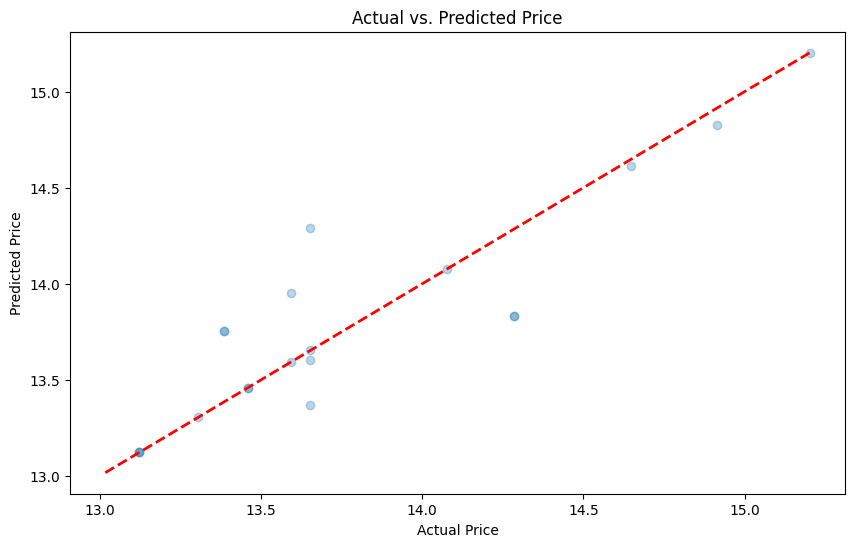

In [111]:
plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y.min(), y.max(),], [y.min(), y.max()], "r--", lw=2)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs. Predicted Price')
plt.show()